# Train SVM classifiers for poet profiling (época, century)

In [1]:
from format import *
import features
import svm_classifier
import torch
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
%matplotlib inline

/Users/menga/opt/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load in the training data. Then extract features to turn poem into vector.

In [2]:
df_train, df_test = get_text_to_period()
df_train = df_train.where(df_train['content'].apply(lambda x: isinstance(x, str) and x.strip() != '')).dropna()

df_test = df_test.where(df_test['content'].apply(lambda x: isinstance(x, str) and x.strip() != '')).dropna()

# no need to map, since labels are numeric
categories = get_periods()
periodsMap = {categories[i] : i for i in range(len(categories))}
df_train['normdate'] = df_train['normdate'].map(periodsMap)
df_train = df_train.dropna(subset=['normdate'])

df_test['normdate'] = df_test['normdate'].map(periodsMap)
df_test = df_test.dropna(subset=['normdate'])

df_train = df_train.dropna(subset=['rhyme'])
df_train = df_train.dropna(subset=['met'])

df_test = df_test.dropna(subset=['rhyme'])
df_test = df_test.dropna(subset=['met'])

In [3]:
# what does 16th ctry split look like
print(categories)
df_train.where(df_train['normdate']==4).count()

[15.0, 16.0, 17.0, 18.0, 19.0]


content     2772
normdate    2772
rhyme       2772
met         2772
dtype: int64

Some features (BoW and prosodic attributes)

In [25]:
# unigram and bigrams (just to check these out)
unigrams, bigrams = features.get_top_n_vocab(df_train['content'], n=2000)
print(unigrams[:10]) # full output is a lot
print(bigrams[:10])

['de', 'y', 'la', 'el', 'que', 'en', 'a', 'su', 'del', 'al']
[('de', 'la'), ('en', 'la'), ('en', 'el'), ('a', 'la'), ('y', 'el'), ('que', 'en'), ('de', 'su'), ('y', 'en'), ('de', 'mi'), ('que', 'el')]


In [5]:
reload(features);

In [6]:
out_vect, uni_vocab, bi_vocab, tf_uni, tf_bi, idf_uni, idf_bi = features.get_tfidf_vocab(df_train['content'], n = 2000)
rm_vect = features.get_rhyme_meter_vectors(df_train['rhyme'], df_train['met'])
rm_tensor = torch.Tensor(rm_vect)
input = torch.hstack((torch.Tensor(out_vect), rm_tensor))
print(rm_vect)

[[1, 2, 2, 1, 1, 2, 2, 1, 3, 4, 3, 4, 3, 4, -1, -1, -1, -1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, -1, -1, -1, -1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, -1, -1, -1, -1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, -1, -1, -1, -1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, -1, -1, -1, -1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, -1, -1, -1, -1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0], [1, 2, 2, 1, 1, 2, 2, 1, 3, 4, 5, 3, 4, 5, -1, -1, -1, -1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, -1, -1, -1, -1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 1, 0,

In [7]:
input_arr = input

label_arr = torch.Tensor(df_train['normdate'].values)

print(input_arr.shape)
print(label_arr.shape)

torch.Size([4008, 4224])
torch.Size([4008])


Create SVM model.

In [8]:
reload(svm_classifier);

In [9]:
model = svm_classifier.MulticlassSVM(input_arr.shape[1], len(categories))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

epochs = 5

for epoch in range(epochs):
    outputs = model(input_arr)
    loss = model.hinge_loss(outputs.float(), label_arr.long())
    print(f'Epoch {epoch}: Hinge Loss is {loss.item()}')
    with torch.no_grad():
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == label_arr).sum().item()
        print(f'Train accuracy: {correct / label_arr.size(0):.3f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0: Hinge Loss is 3.2308530807495117
Train accuracy: 0.682
Epoch 1: Hinge Loss is 2.219494342803955
Train accuracy: 0.692
Epoch 2: Hinge Loss is 2.334016799926758
Train accuracy: 0.692
Epoch 3: Hinge Loss is 2.5485918521881104
Train accuracy: 0.692
Epoch 4: Hinge Loss is 2.6541738510131836
Train accuracy: 0.692


Evaluate on test set

In [10]:
# just tfidf bow
# vars for ref: uni_vocab, bi_vocab, tf_uni, tf_bi, idf_uni, idf_bi
test_tfidf = torch.Tensor([features.get_tfidf_test(text, uni_vocab, bi_vocab, tf_uni, tf_bi, idf_uni, idf_bi) for text in df_test['content']])
test_rm = torch.Tensor(features.get_rhyme_meter_vectors(df_test['rhyme'], df_test['met']))

input_arr_test = torch.hstack((test_tfidf, test_rm))
label_arr_test = torch.Tensor(df_test['normdate'].values)
print(input_arr_test.shape)
print(label_arr_test.shape)

torch.Size([444, 4224])
torch.Size([444])


In [11]:
test_outputs = model(input_arr_test)
test_loss = model.hinge_loss(test_outputs.float(), label_arr_test.long())
print(f'Test loss: {test_loss.item()}')
with torch.no_grad():
    test_predictions = torch.argmax(test_outputs, dim=1)
    test_correct = (test_predictions == label_arr_test).sum().item()
    print(f'Test accuracy: {test_correct / label_arr_test.size(0):.3f}')

Test loss: 2.6529276371002197
Test accuracy: 0.694


Is this any better than always predicting 19th century?

In [12]:
print(test_predictions)
print(label_arr_test)
always19 = (label_arr_test == torch.zeros(label_arr_test.shape)).sum().item()
print(f'Test accuracy: {always19 / label_arr_test.size(0):.3f}')
# Answer: no, not really. It just sets things to 19th century

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

Weighted SVM approach

In [13]:
reload(svm_classifier);
# 0, then 1
class_count = np.bincount(label_arr, minlength=len(categories))

# normalized inverse class weight
class_weights = torch.Tensor(len(label_arr) / (len(categories) * class_count))
print(class_count)

print(class_weights)


[  48  471  436  281 2772]
tensor([16.7000,  1.7019,  1.8385,  2.8527,  0.2892])


In [14]:
model = svm_classifier.MulticlassSVM(input_arr.shape[1], len(categories))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

epochs = 500 # note: we need to train longer than previously

for epoch in range(epochs):
    outputs = model(input_arr)
    loss = model.hinge_loss(outputs.float(), label_arr.long(), class_weights=class_weights)
    print(f'Epoch {epoch}: Hinge Loss is {loss.item()}')
    with torch.no_grad():
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == label_arr).sum().item()
        print(f'Train accuracy: {correct / label_arr.size(0):.3f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0: Hinge Loss is 3.9899253845214844
Train accuracy: 0.142
Epoch 1: Hinge Loss is 3.724993944168091
Train accuracy: 0.132
Epoch 2: Hinge Loss is 3.4800169467926025
Train accuracy: 0.175
Epoch 3: Hinge Loss is 3.2687697410583496
Train accuracy: 0.198
Epoch 4: Hinge Loss is 3.091167449951172
Train accuracy: 0.233
Epoch 5: Hinge Loss is 2.900545358657837
Train accuracy: 0.252
Epoch 6: Hinge Loss is 2.725285768508911
Train accuracy: 0.298
Epoch 7: Hinge Loss is 2.6277124881744385
Train accuracy: 0.251
Epoch 8: Hinge Loss is 2.503676414489746
Train accuracy: 0.272
Epoch 9: Hinge Loss is 2.367021083831787
Train accuracy: 0.327
Epoch 10: Hinge Loss is 2.2829065322875977
Train accuracy: 0.334
Epoch 11: Hinge Loss is 2.2310900688171387
Train accuracy: 0.314
Epoch 12: Hinge Loss is 2.152012825012207
Train accuracy: 0.340
Epoch 13: Hinge Loss is 2.064957857131958
Train accuracy: 0.391
Epoch 14: Hinge Loss is 2.0087625980377197
Train accuracy: 0.398
Epoch 15: Hinge Loss is 1.968841791152954
T

In [15]:
test_outputs = model(input_arr_test)
test_loss = model.hinge_loss(test_outputs.float(), label_arr_test.long(), class_weights=class_weights)
print(f'Test loss: {test_loss.item()}')
with torch.no_grad():
    test_predictions = torch.argmax(test_outputs, dim=1)
    test_correct = (test_predictions == label_arr_test).sum().item()
    print(f'Test accuracy: {test_correct / label_arr_test.size(0):.3f}')

Test loss: 2.26169490814209
Test accuracy: 0.779


In [16]:
print(test_predictions)

tensor([4, 4, 4, 3, 4, 4, 4, 4, 1, 0, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1,
        3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4,
        4, 4, 2, 4, 2, 3, 4, 1, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 1, 2, 4, 4, 4, 4,
        4, 3, 4, 2, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 1,
        4, 1, 4, 4, 1, 4, 4, 4, 3, 1, 4, 4, 4, 3, 4, 4, 4, 2, 4, 4, 1, 3, 4, 2,
        3, 3, 4, 1, 4, 2, 4, 4, 4, 1, 4, 4, 4, 2, 4, 3, 4, 4, 4, 4, 2, 4, 4, 1,
        3, 4, 2, 3, 4, 2, 4, 4, 4, 4, 2, 3, 4, 4, 4, 4, 2, 4, 4, 4, 4, 1, 4, 4,
        2, 1, 1, 1, 4, 1, 3, 4, 1, 4, 3, 2, 3, 1, 4, 3, 4, 0, 3, 1, 4, 4, 4, 4,
        2, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 1, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 2, 1, 4, 3, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 1, 3, 4, 4,
        3, 4, 4, 1, 4, 3, 2, 4, 1, 2, 1, 3, 2, 4, 4, 4, 4, 1, 3, 1, 4, 4, 4, 4,
        3, 1, 1, 2, 1, 4, 4, 2, 4, 1, 4, 3, 4, 3, 4, 3, 4, 4, 2, 4, 4, 4, 4, 4,
        4, 4, 1, 4, 4, 4, 3, 2, 2, 4, 2,

In [17]:
actuals = test_predictions.detach().cpu().tolist()
expecteds = label_arr_test.detach().cpu().tolist()

# sort country ids
classes = sorted(set(expecteds))
num_classes = len(classes)

label_to_index = {label: idx for idx, label in enumerate(classes)}

mtrx = np.zeros((num_classes, num_classes), dtype=int)

for actual, predicted in zip(expecteds, actuals):
    i = label_to_index[actual]
    j = label_to_index[predicted]
    mtrx[i, j] += 1

# normalize each row (per actual class)
mtrx_normal = mtrx.astype(float) / mtrx.sum(axis=1, keepdims=True)

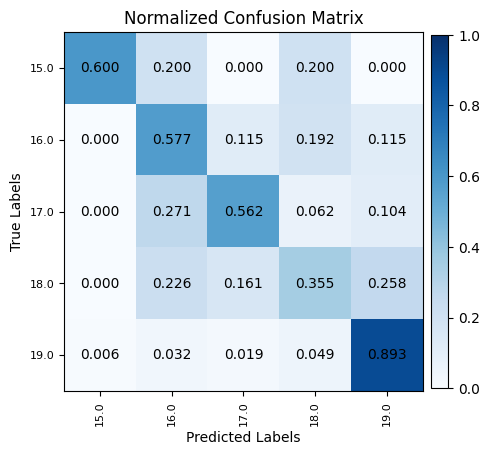

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))

im = ax.imshow(mtrx_normal, cmap='Blues', vmin=0, vmax=1)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Normalized Confusion Matrix')

ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))

# map back to labels
int_to_period = {v: k for k, v in periodsMap.items()}
labels = [int_to_period[label] for label in classes]

ax.set_xticklabels(labels, rotation=90, fontsize=8)
ax.set_yticklabels(labels, fontsize=8)

# Write normalized values inside cells
for i in range(num_classes):
    for j in range(num_classes):
        value = mtrx_normal[i, j]
        if not np.isnan(value):  # avoid printing if row sum was zero
            ax.text(j, i, f'{value:.3f}', ha='center', va='center', color='black')

plt.colorbar(im, fraction=0.046, pad=0.02)
plt.tight_layout()
plt.show()

In [19]:
weights = model.fc.weight.data.numpy()  # shape: (num_classes, input_dim)
np.savetxt("svm_epoca_weights.csv", weights, delimiter=",")


In [24]:
print(periodsMap)
print(len(bigrams))
print(bigrams[3622 - 2000])

{15.0: 0, 16.0: 1, 17.0: 2, 18.0: 3, 19.0: 4}
1000


IndexError: list index out of range